## Visualize our Method and Baselines (LBFGS, DPS) in a Video

Load the results of our method and the baselines (LBFGS, DPS) and visualize them in a video. 

In [1]:
import pickle

# LBFGS
file_lbfgs = 'github/smdp/buoyancy-flow/evaluation/results/results_lbfgs.pkl'
with open(file_lbfgs, 'rb') as f:
    data_lbfgs = pickle.load(f)
    
# DPS
file_dps = 'github/smdp/buoyancy-flow/evaluation/results/results_dps.pkl'
with open(file_dps, 'rb') as f:
    data_dps = pickle.load(f)
    
# Our Method (ODE, SDE with separate updates)
file_ours = 'github/smdp/buoyancy-flow/evaluation/results/results_ours.pkl'
with open(file_ours, 'rb') as f:
    data_ours = pickle.load(f)

This code was used to convert the old data format to the new format.  

In [2]:
# data_ours_new = {}
# for key in data_ours[0.01].keys():
#     data_ours_new[key] = {}
#     data_ours_new[key]['ground_truth'] = data_ours[0.01][key]['ground_truth']
#     data_ours_new[key]['reverse_sde_no_noise'] = data_ours[0.01][key]['reverse_sde_no_noise']
#     data_ours_new[key]['reverse_sde_0'] = data_ours[0.01][key]['reverse_sde_0']
#     data_ours_new[key]['reverse_sde_1'] = data_ours[0.01][key]['reverse_sde_1']
#     data_ours_new[key]['reverse_sde_2'] = data_ours[0.01][key]['reverse_sde_2']
#     
#     data_ours_new[key]['reverse_sde_no_noise_simu'] = data_ours[0.01][key]['forward'][30]['reverse_sde_no_noise']
#     data_ours_new[key]['reverse_sde_0_simu'] = data_ours[0.01][key]['forward'][30]['reverse_sde_0']
#     data_ours_new[key]['reverse_sde_1_simu'] = data_ours[0.01][key]['forward'][30]['reverse_sde_1']
#     data_ours_new[key]['reverse_sde_2_simu'] = data_ours[0.01][key]['forward'][30]['reverse_sde_2']
#     
# # save with pickle
# file_ours_new = 'github/smdp/buoyancy-flow/evaluation/results/results_ours.pkl'
# with open(file_ours_new, 'wb') as f:
#     pickle.dump(data_ours_new, f)

This is the index/key we want to plot.

In [3]:
idx = '3'
file = 'github/smdp/buoyancy-flow/data/smoke_plumes_test_r0.h5'

Define the data we want to plot and the plotting function.

In [4]:
import numpy as np
import matplotlib.pyplot as plt

DT = 0.01

data = {
    'lbfgs': data_lbfgs[(file, idx)],
    'dps': data_dps[(file, idx)],
    'ours': data_ours[idx]['ground_truth'],
    'ours_ode': data_ours[idx]['reverse_sde_no_noise'],
    'ours_sde': data_ours[idx]['reverse_sde_0'],
    'ours_ode_simu': data_ours[idx]['reverse_sde_no_noise_simu'],
    'ours_sde_0_simu': data_ours[idx]['reverse_sde_0_simu'],
    'ground_truth' : data_ours[idx]['ground_truth']
}

def fill_axis(ax, data, title, norm=None):
    
    marker_idx = 0
    mask_idx = 3
    
    if norm is None:
        vmin = np.min(data[marker_idx])
        vmax = np.max(data[marker_idx])
    else:
        vmin, vmax = norm
        
    data_with_mask = data[marker_idx] * data[mask_idx] + (1-data[mask_idx]) * vmax
    ax.imshow(np.flip(data_with_mask[0], axis=0), cmap='jet', vmin = vmin, vmax = vmax)
     
    ax.set_xticks([])
    ax.set_yticks([])

    ax.set_xlabel(title)

def plot_frame(data, title, norm=None):
    
    height = 3
    width = 15
    dpi = 100
    
    lbfgs = data['lbfgs']
    dps = data['dps']
    ours_ode = data['ours_ode']
    ours_sde = data['ours_sde']
    ground_truth = data['ground_truth']
    
    fig, axes = plt.subplots(1, 5, figsize=(width, height))
    
    fill_axis(axes[0], ground_truth, 'Ground truth', norm=norm)
    fill_axis(axes[1], ours_ode, 'Ours (ODE)', norm=norm)
    fill_axis(axes[2], ours_sde, 'Ours (SDE)', norm=norm)
    fill_axis(axes[3], lbfgs, 'LBFGS', norm=norm)
    fill_axis(axes[4], dps, 'DPS', norm=norm)
    
    fig.suptitle(title)
    
    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    
    plt.close(fig)
    
    return image.reshape(dpi * height, dpi * width, 3)
    
def make_video(data):
    
    # backwards
 
    frames = []
    
    vmin = np.min(data['ground_truth'][0][0])
    vmax = np.max(data['ground_truth'][0][0])
    norm = (vmin, vmax)
 
    for time_idx in range(31):
    
        frame = {
            'lbfgs': data['lbfgs'][0],
            'dps': data['dps'][0],
            'ours_ode': data['ours_ode'][time_idx],
            'ours_sde': data['ours_sde'][time_idx],
            'ground_truth' : data['ground_truth'][time_idx]
        }
        
        frames.append(plot_frame(frame, 't = {:.2f}'.format(0.65 - time_idx * DT), norm=norm))
    
    # add 5 frames in the beginning
    frames = [frames[0]]*5 + frames
    
    # add 20 frames for the solution, pause
    frames = frames + [frames[-1]]*20
    
    # forwards
    
    for time_idx in range(31):

        frame = {
            'lbfgs': data['lbfgs'][time_idx],
            'dps': data['dps'][time_idx],
            'ours_ode': data['ours_ode_simu'][time_idx],
            'ours_sde': data['ours_sde_0_simu'][time_idx],
            'ground_truth' : data['ground_truth'][::-1][34 + time_idx]
        }
        
        frames.append(plot_frame(frame, 't = {:.2f}'.format(0.35 + time_idx * DT), norm=norm))
        
    # add 20 frames in the end
    frames = frames + [frames[-1]]*20
    
    return frames

Get individual video frames.

In [5]:
frames = make_video(data)

Save frames using moviepy as a .mp4 file.

In [6]:
import moviepy.editor as mp

savename = 'github/smdp/buoyancy-flow/evaluation/videos/comparison_methods.mp4'

clip = mp.ImageSequenceClip(frames, fps=8)
    
clip.write_videofile(savename, fps=8)



Moviepy - Building video github/smdp/buoyancy-flow/evaluation/videos/comparison_methods.mp4.
Moviepy - Writing video github/smdp/buoyancy-flow/evaluation/videos/comparison_methods.mp4


Moviepy - Done !
Moviepy - video ready github/smdp/buoyancy-flow/evaluation/videos/comparison_methods.mp4


### Plot different solutions from SDE
Based on the random noise of the SDE, we get different solutions. We plot three different solutions from the SDE at simulation step $t=0.35$.       

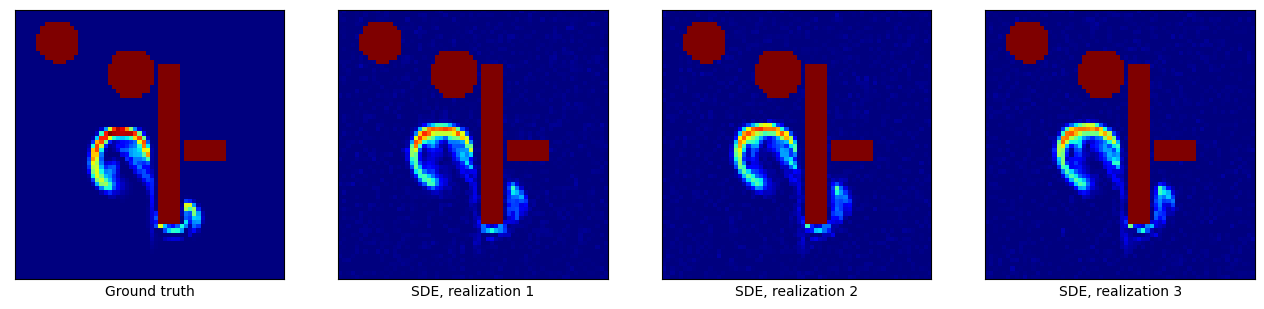

In [7]:
import matplotlib.pyplot as plt 

fig, axes = plt.subplots(1, 4, figsize=(16, 4))

time_idx = 30

vmin = np.min(data_ours[idx]['ground_truth'][time_idx][0])
vmax = np.max(data_ours[idx]['ground_truth'][time_idx][0])

fill_axis(axes[0], data_ours[idx]['ground_truth'][time_idx], 'Ground truth')
fill_axis(axes[1], data_ours[idx]['reverse_sde_0'][time_idx], 'SDE, realization 1', norm=(vmin, vmax))
fill_axis(axes[2], data_ours[idx]['reverse_sde_1'][time_idx], 'SDE, realization 2', norm=(vmin, vmax))
fill_axis(axes[3], data_ours[idx]['reverse_sde_2'][time_idx], 'SDE, realization 3', norm=(vmin, vmax))